# CNN in PyTorch

In [53]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
# load a sample image
img = Image.open("car.jpg").convert("RGB")

# Transform to tensor (C,H,W) and normalize to [0,1]
# C: channel (features), H: height, W: width

transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
img.size # (W, H)

(760, 506)

In [55]:
img_tensor = transform(img).unsqueeze(0).to(device) # shape: (1, 3, 128, 128)
img_tensor.shape # (1, C, H, W)

torch.Size([1, 3, 256, 256])

Text(0.5, 1.0, 'Original Image')

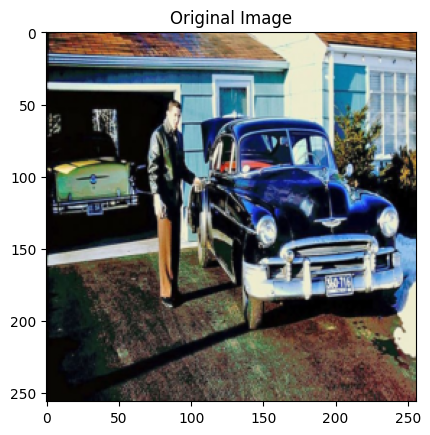

In [57]:
plt.figure(1)
plt.imshow(img_tensor.cpu().squeeze(0).permute(1, 2, 0)) # # Tensor: (1, 3, H, W) → (H, W, 3)
plt.title("Original Image")


## Apply conv 2D

We will use random arguments in the Conv2D layer to see how it works.

In [60]:
conv = nn.Conv2d(in_channels = 3,
                 out_channels = 8,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1
).to(device)

# PyTorch automatically initializes the weights and biases  for each of the 8 output channels
# Each of those channels has its own set of 3 (C)×3 (H)×3 (W) filters
# conv2d generates 2d output from 2d input, so we get 8 2d images as output 
#
with torch.no_grad():
    output = conv(img_tensor)

print("conv :",conv)
print("Conv weight matrix (output_channel, channels (RGB), H, W):", conv.weight.shape)
print("Conv filter shape (channels (RGB), H, W):", conv.weight[0].shape)

conv : Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv weight matrix (output_channel, channels (RGB), H, W): torch.Size([8, 3, 3, 3])
Conv filter shape (channels (RGB), H, W): torch.Size([3, 3, 3])


In [61]:
output.shape

torch.Size([1, 8, 256, 256])

### Visualise the feature maps after applying the Conv2D layer

In [62]:
i = 0

for i in range(8):
    print("Loop number: ", i)
    #print(i/4, i%4)
    print("\t  plot number", i//4, i%4)



Loop number:  0
	  plot number 0 0
Loop number:  1
	  plot number 0 1
Loop number:  2
	  plot number 0 2
Loop number:  3
	  plot number 0 3
Loop number:  4
	  plot number 1 0
Loop number:  5
	  plot number 1 1
Loop number:  6
	  plot number 1 2
Loop number:  7
	  plot number 1 3


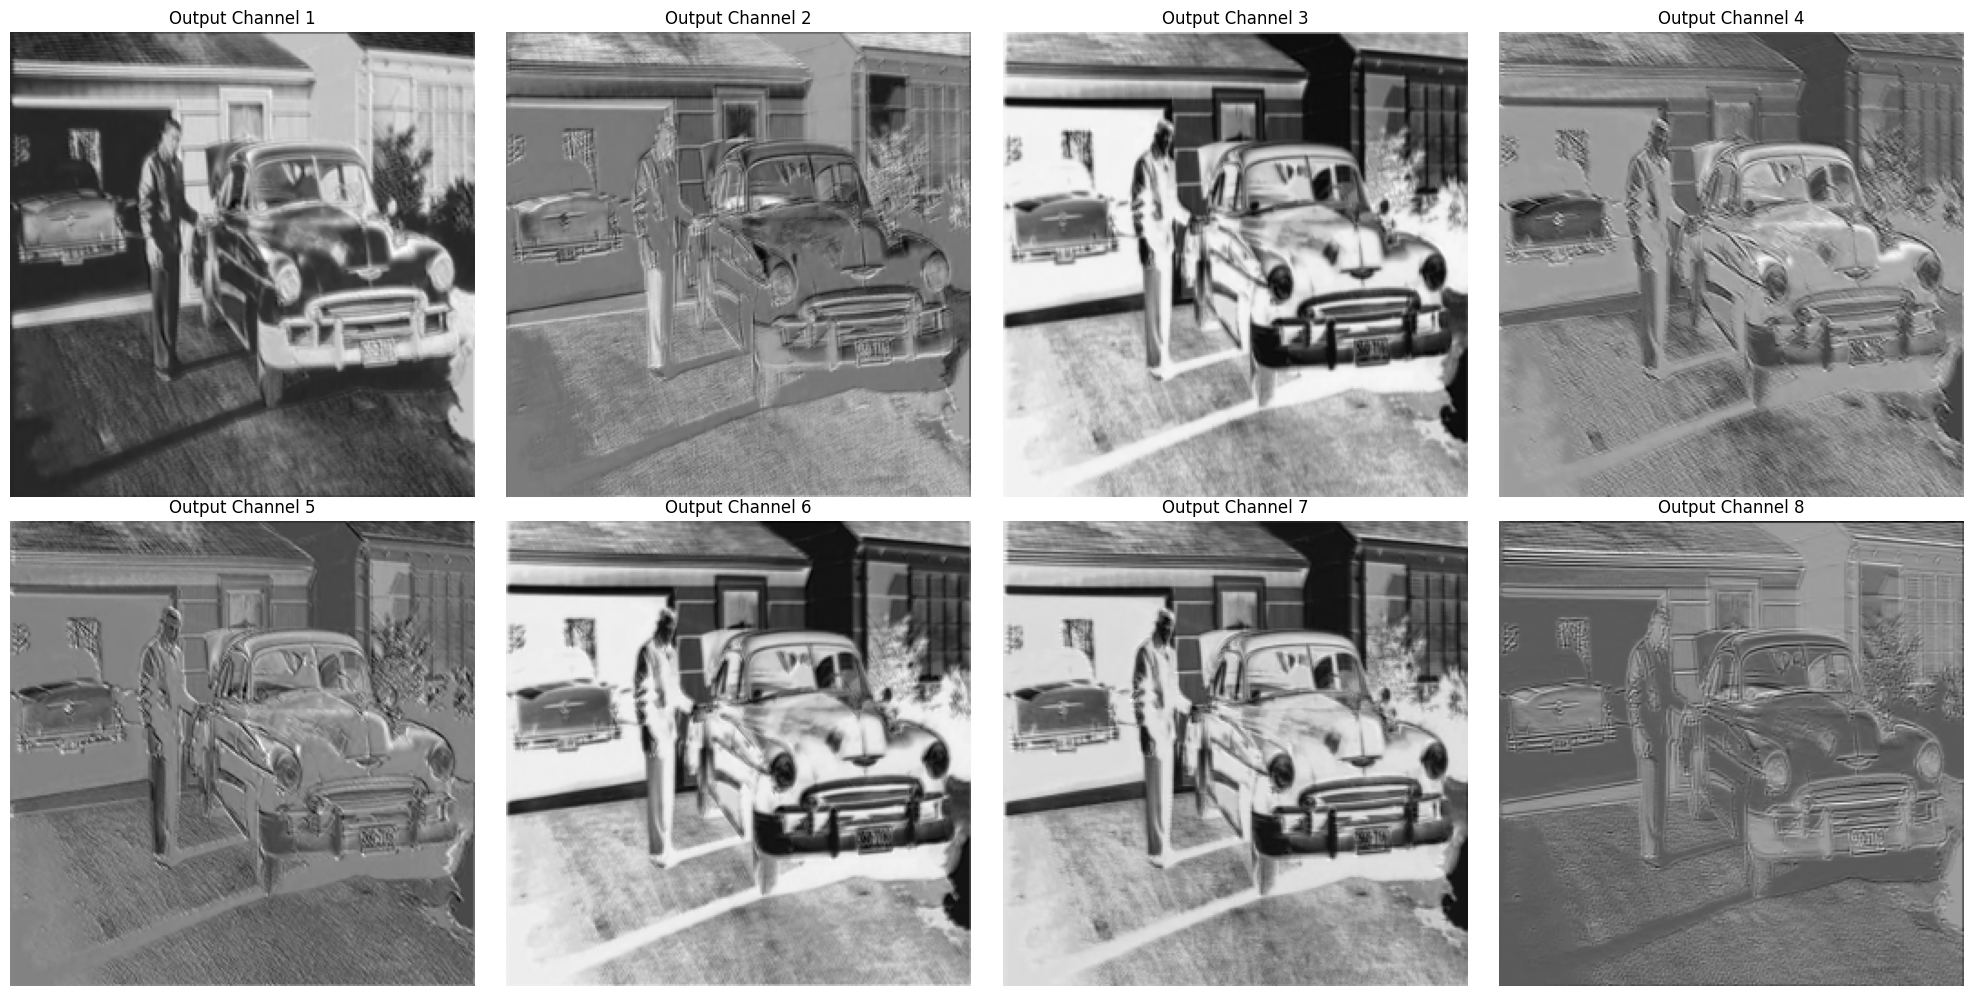

In [64]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range (8): # 8 out_channels
    axs[i//4, i%4].imshow(output[0, i, :, :].cpu().numpy(), cmap='gray') # i is looping over each output channel
    axs[i//4, i%4].set_title(f"Output Channel {i+1}") # i+1 because i starts from 0
    axs[i//4, i%4].axis('off')
plt.tight_layout()

In [84]:
# we will use this plotting function multiple times, so let us make a function
import matplotlib.pyplot as plt

def visualize_feature_maps(tensor, fig_num, title_prefix="Channel"):
    """
    Plots the first `max_channels` feature maps from a 4D tensor of shape (1, C, H, W).
    This is very hardcoded function, don't try fancy things.
    """
    plt.figure(fig_num)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i in range (8): # 8 out_channels
        axs[i//4, i%4].imshow(tensor[0, i].cpu().numpy(), cmap='gray') # i is looping over each output channel
        axs[i//4, i%4].set_title(title_prefix +"  " + str(i+1)) # i+1 because i starts from 0
        axs[i//4, i%4].axis('off')
    plt.tight_layout()


These are different filters applied to the input image based on the weights, stride, padding etc.

### Max pooling
We’ll apply a 2×2 max pooling with stride 2 — this will reduce spatial size by half.

In [65]:
pool = nn.MaxPool2d(kernel_size = 2, stride = 2).to(device)

with torch.no_grad():
    pooled = pool(output)

print("conv :",pooled.shape) # reduced by half

conv : torch.Size([1, 8, 128, 128])


In [85]:
visualize_feature_maps(pooled, 1, title_prefix="Pooled Channel")

<Figure size 640x480 with 0 Axes>

MaxPool doesn't learn or add anything but reduced the spatial dimension by keeping the maximum values in each passing window. So finer detail are lost  but stronger features stay.

### Activation function
This time we are gonna apply relu. So, the process will be:

Conv -> ReLU -> MaxPool

In [67]:
conv = nn.Conv2d(in_channels = 3,
                 out_channels = 8,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1
).to(device)

relu = nn.ReLU().to(device)

pool = nn.MaxPool2d(kernel_size = 2, stride = 2).to(device)

In [68]:
with torch.no_grad():
    x = conv(img_tensor)
    x_relu = relu(x)
    x_pooled = pool(x_relu)

print("Initial Image Shape:", img_tensor.shape) # contains input channel
print("Convolution Output Shape:", x.shape) # contains output channel
print("ReLU Output Shape:", x_relu.shape) # same as x, just a pass through
print("MaxPool Output Shape:", x_pooled.shape) # reduced by half

Initial Image Shape: torch.Size([1, 3, 256, 256])
Convolution Output Shape: torch.Size([1, 8, 256, 256])
ReLU Output Shape: torch.Size([1, 8, 256, 256])
MaxPool Output Shape: torch.Size([1, 8, 128, 128])


In [86]:
visualize_feature_maps(x_relu, 2, title_prefix="ReLU Channel") # visualize ReLU output

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

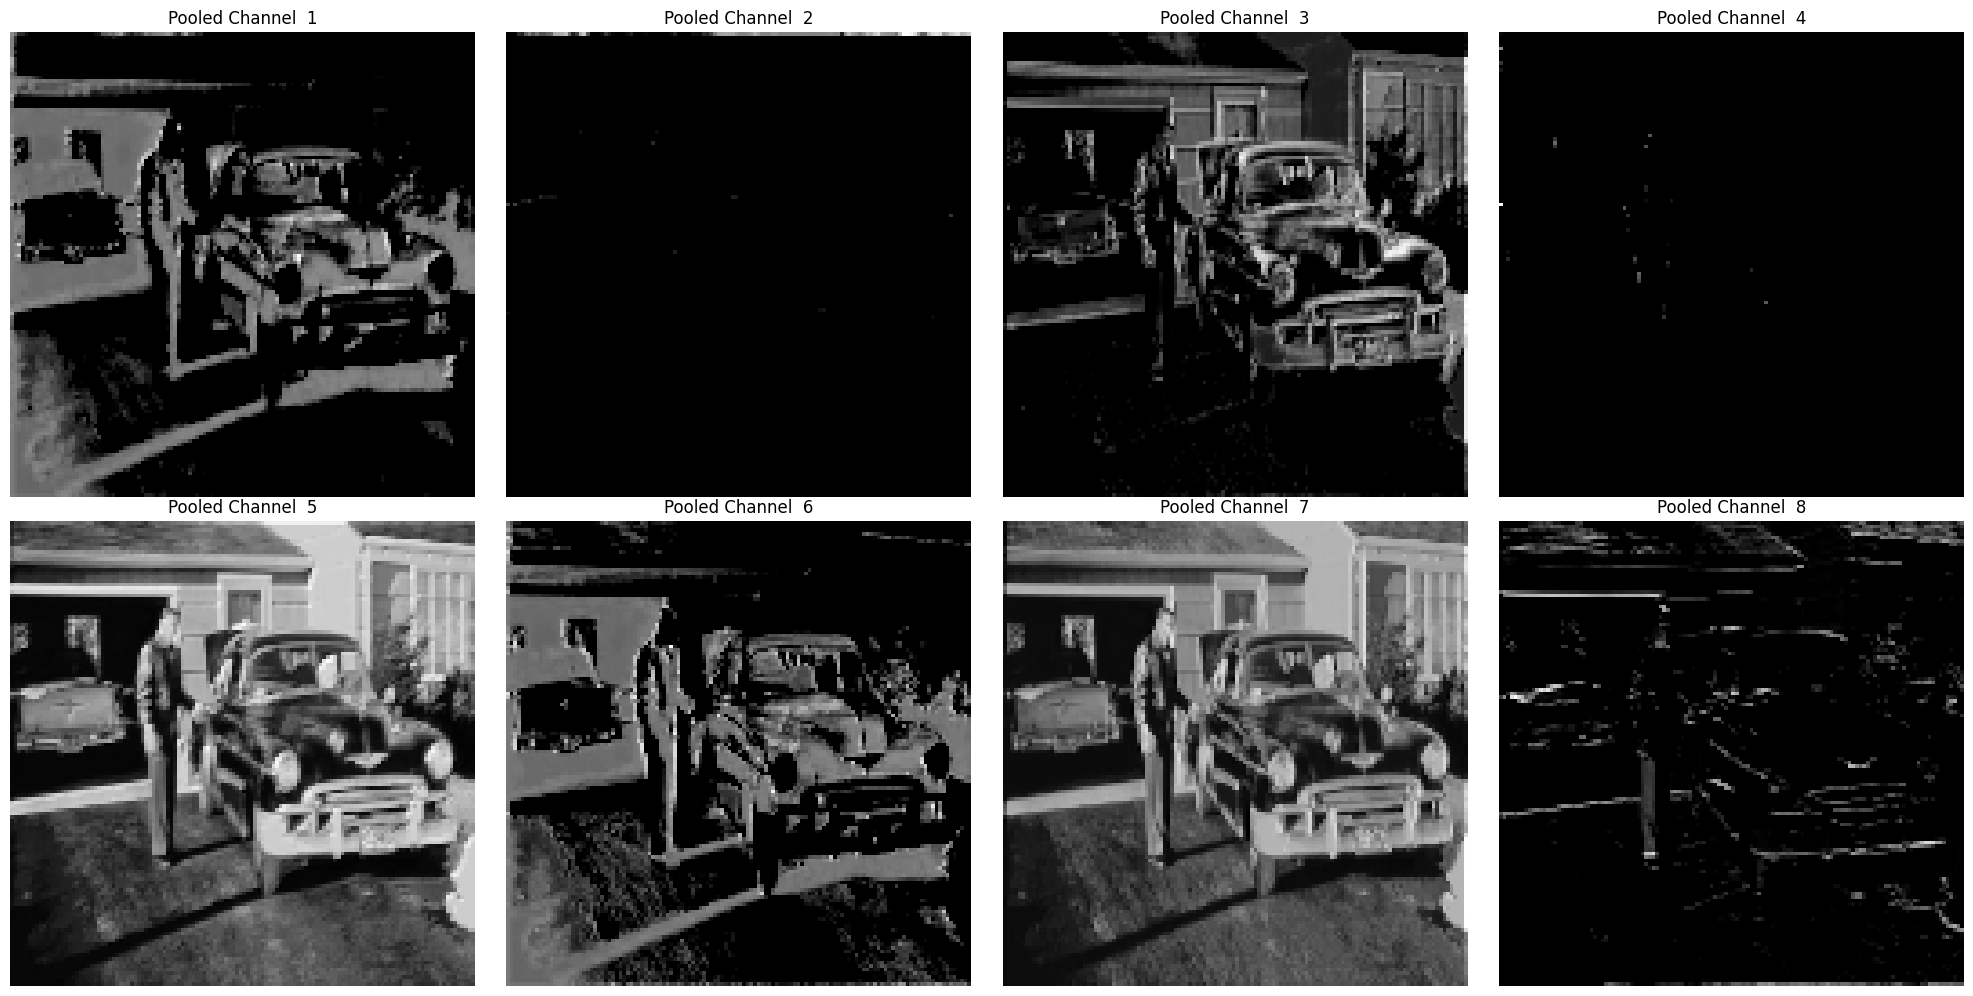

In [87]:
# visualise the max pooled output
visualize_feature_maps(x_pooled, 3, title_prefix="Pooled Channel")

ReLU being shit, rejects everything below zero. So, max pool can't do any magic here. Let us try Leaky relu.

## Substitute ReLU with LeakyReLU

In [88]:
conv = nn.Conv2d(in_channels = 3,
                 out_channels = 8,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1
).to(device)

relu = nn.LeakyReLU(0.1).to(device)

pool = nn.MaxPool2d(kernel_size = 2, stride = 2).to(device)

In [89]:
with torch.no_grad():
    x = conv(img_tensor)
    x_relu = relu(x)
    x_pooled = pool(x_relu)

print("Initial Image Shape:", img_tensor.shape) # contains input channel
print("Convolution Output Shape:", x.shape) # contains output channel
print("ReLU Output Shape:", x_relu.shape) # same as x, just a pass through
print("MaxPool Output Shape:", x_pooled.shape) # reduced by half

Initial Image Shape: torch.Size([1, 3, 256, 256])
Convolution Output Shape: torch.Size([1, 8, 256, 256])
ReLU Output Shape: torch.Size([1, 8, 256, 256])
MaxPool Output Shape: torch.Size([1, 8, 128, 128])


<Figure size 640x480 with 0 Axes>

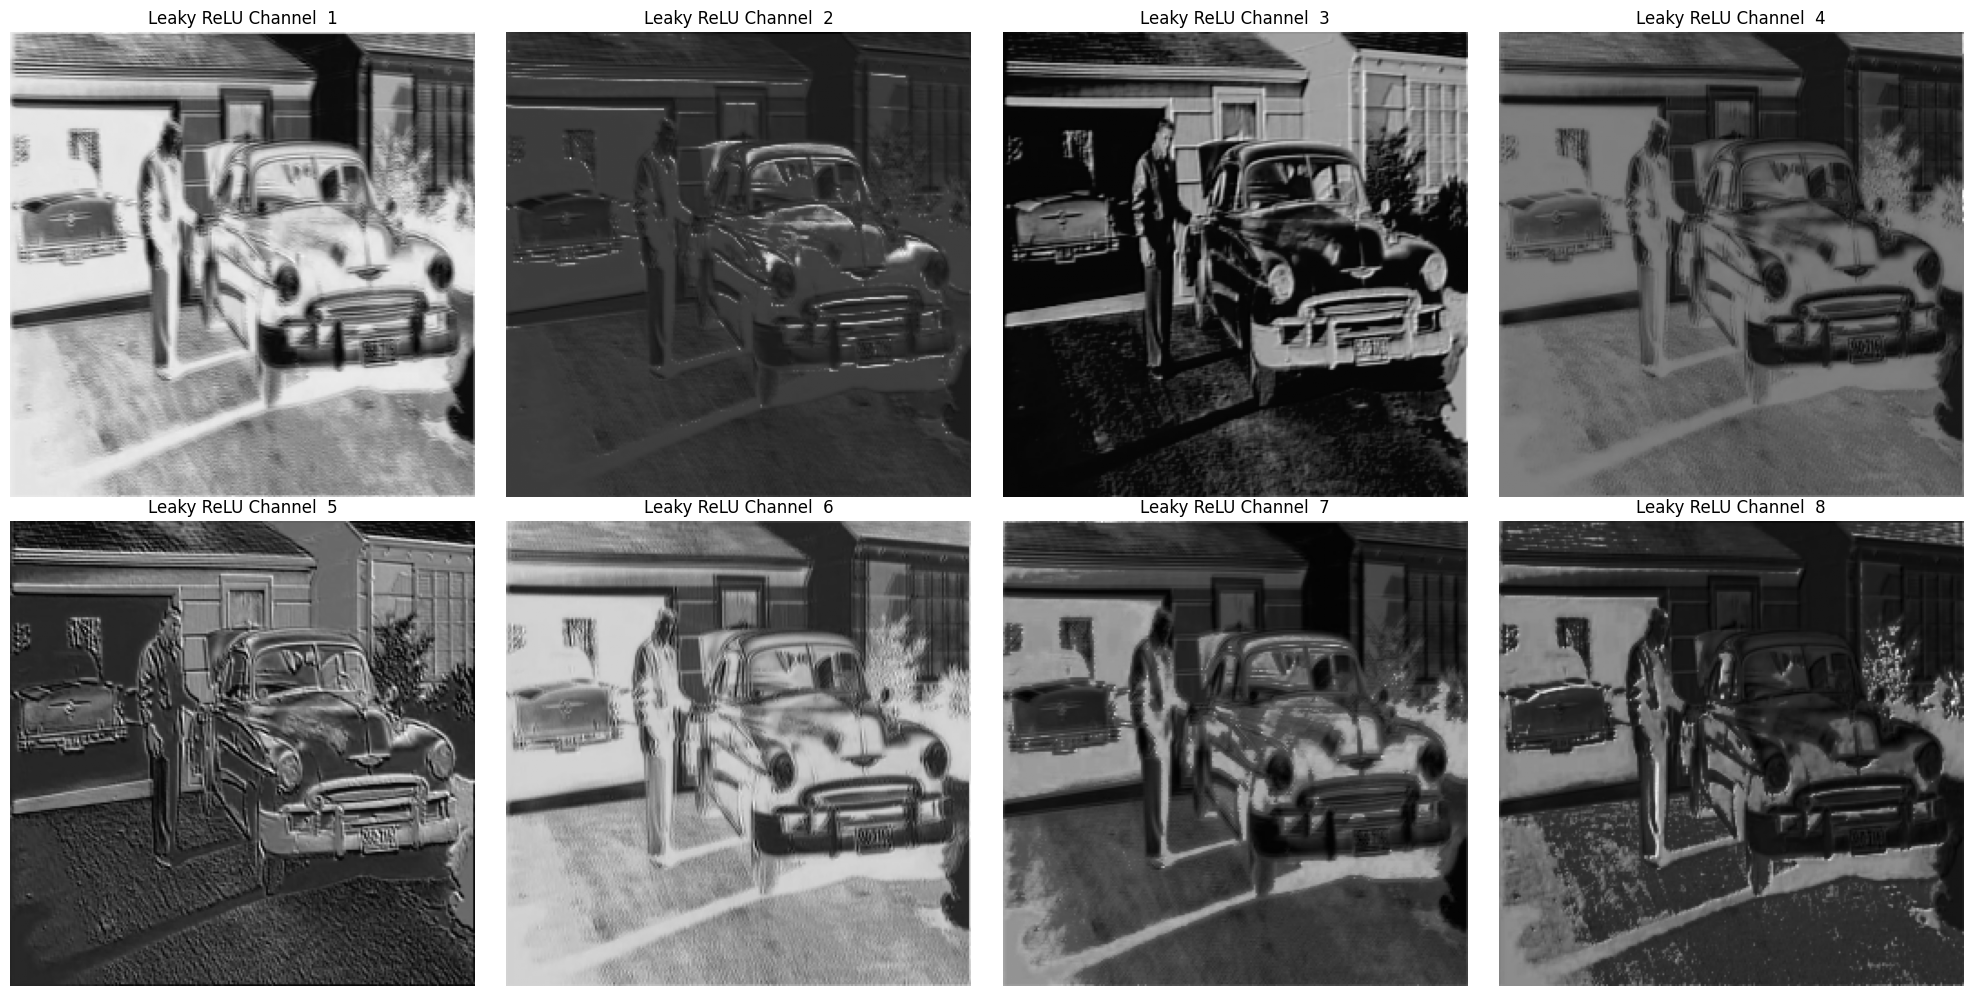

In [90]:
visualize_feature_maps(x_relu, 4, title_prefix="Leaky ReLU Channel") # visualize LeakyReLU output

In [91]:
# visualise the max pooled output
visualize_feature_maps(x_pooled, 5, title_prefix="Pooled Channel")

<Figure size 640x480 with 0 Axes>